<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Probability_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
!pip install pyod --quiet

In [123]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
replace /content/SWaT_Dataset_Attack_v0.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [168]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [125]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [126]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [127]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [128]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)


train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


In [129]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [130]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [131]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [132]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction using ECOD

In [169]:
from  pyod.models.ecod import ECOD
start = timeit.default_timer()
model = ECOD(contamination=0.0000001)
model.fit(train_scale)
end = timeit.default_timer()

In [170]:
print(f'total training time {end-start}')

total training time 9.780401902000449


In [171]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data

start = timeit.default_timer()
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test
end = timeit.default_timer()

In [172]:
print(f'total prediction time {end-start}')

total prediction time 25.014701923999382


In [181]:
pd.DataFrame(test_scores).describe()

,0
count,449919.000000
mean,47.068428
std,15.869197
min,24.412061
25%,36.899770
50%,43.259053
75%,51.311999
max,111.768931


In [182]:
pd.DataFrame(train_scores).describe()

,0
count,475200.000000
mean,44.071568
std,9.694732
min,24.888813
25%,36.508637
50%,43.094663
75%,50.165837
max,98.871578


In [183]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

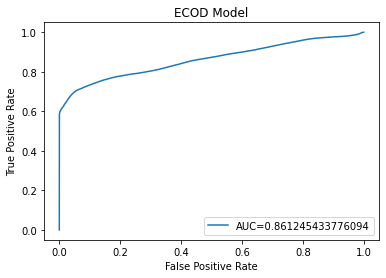

In [184]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ECOD Model')
plt.show()

In [188]:
np.any(np.isnan(test_scores)),np.all(np.isfinite(test_scores))

(False, True)

In [189]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [190]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [191]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_train['type'] = 'train'
df_error_test = pd.DataFrame(norm_test,columns = ['error'])
df_error_test['type'] = 'test'

pd.concat([df_error_train,df_error_test]).to_csv("/content/drive/MyDrive/Data_sci_Project/ECOD/error.csv")

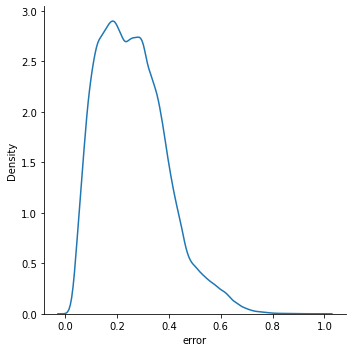

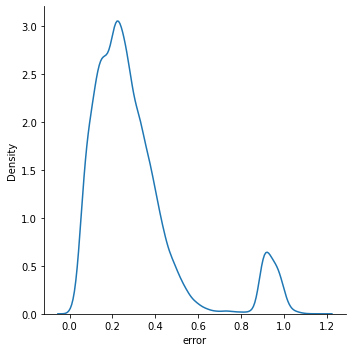

In [192]:
sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")
plt.show()

In [193]:
threshold= np.percentile(norm_test,92)
threshold

0.5971578814105468

In [194]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [195]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [196]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    395298
           1       0.89      0.62      0.73     54621

    accuracy                           0.94    449919
   macro avg       0.92      0.80      0.85    449919
weighted avg       0.94      0.94      0.94    449919



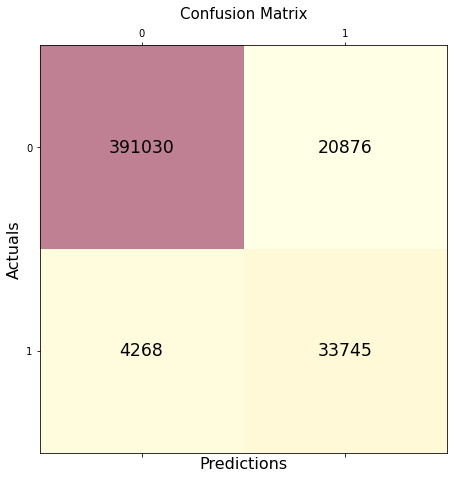

In [197]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [198]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [199]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [200]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [201]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [202]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [203]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [204]:
len(start_time) #there are 36 attack

36

In [205]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [206]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'normal/attack')

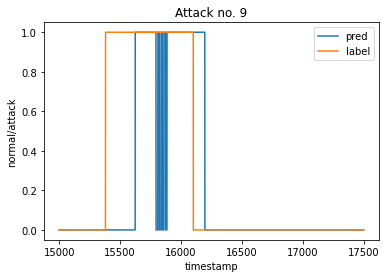

In [207]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 9')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

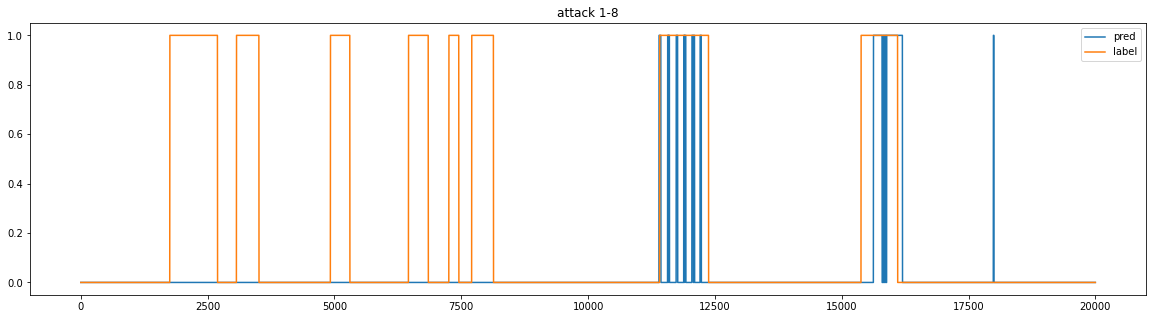

In [208]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

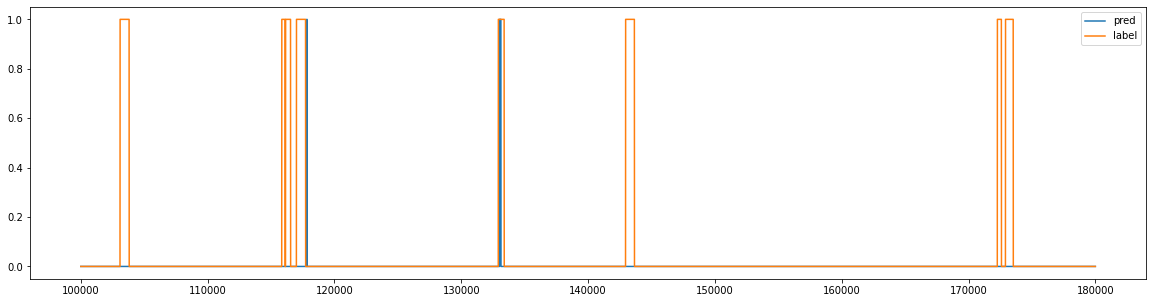

In [209]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

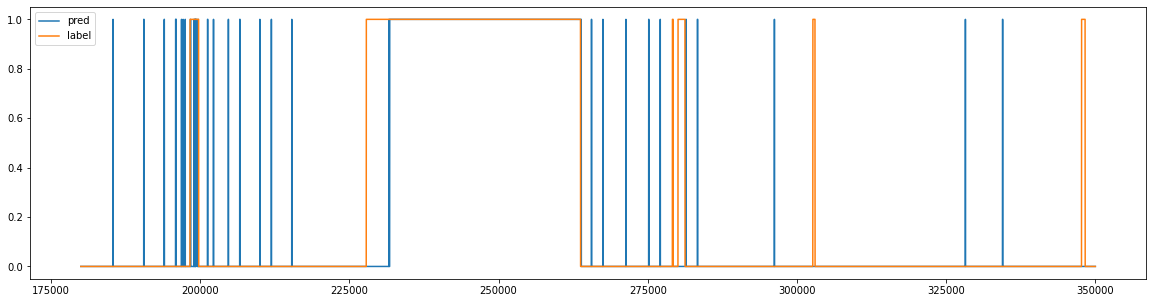

In [210]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

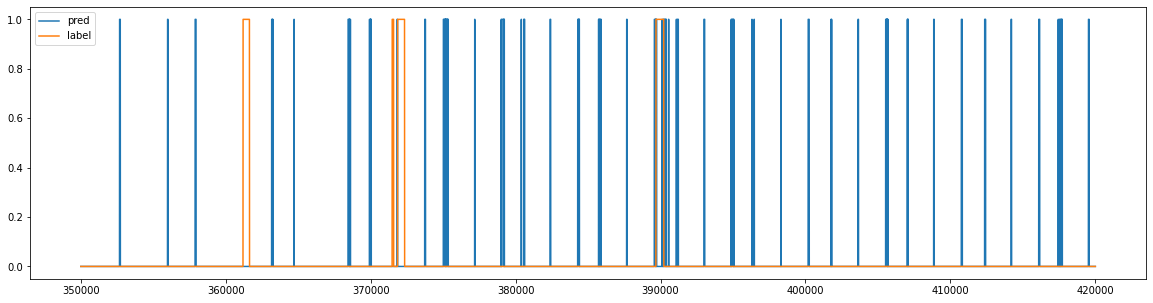

In [211]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

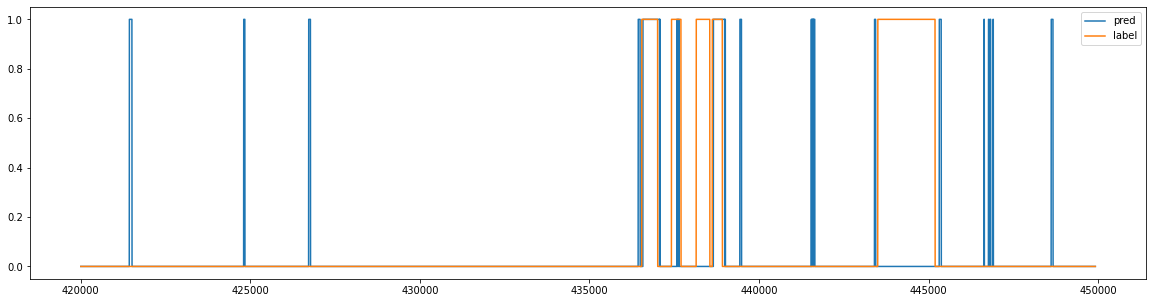

In [212]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

In [213]:
found = []
for i in range(len(time_label)):
  if (time_label.loc[i]["pred"] == 1) & (time_label.loc[i]["label"] == 1):
    found.append(time_label.loc[i]["attack #"])

In [214]:
np.unique(found)

array([ 7, 10, 21, 25, 27, 35, 36, 37, 39])

In [215]:
print(f"There are {len(np.unique(found))} attacks found")

There are 9 attacks found


Apply XAI

##CASE STUDY attack no.10
model cannot detect the anomaly point

### SHAP

In [216]:
!pip install shap --quiet

In [217]:
import shap

In [218]:
def shap_explanation_attack(data,idx_start,idx_end):
  shap_values = []
  X_train_summary = shap.kmeans(train_scale, 50)
  explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary, link="logit")
  for i in range (len(idx_start)):
    sample = shap.sample(data[idx_start[i]:idx_end[i]], 50)
    shap_values.append(explainer.shap_values(X=sample, nsamples=100))
    # print(shap_values)
    # break
  return shap_values


In [219]:
#summarize all the train data using shap.kmeans
X_train_summary = shap.kmeans(train_scale, 50)

In [221]:
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)

In [222]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[7]:idx_end[7]], 100)

In [223]:
np.any(np.isnan(sample)), np.all(np.isfinite(sample))

(False, True)

In [224]:
start = timeit.default_timer()
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)
end = timeit.default_timer()

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [225]:
print(end-start)

1738.2736336410017


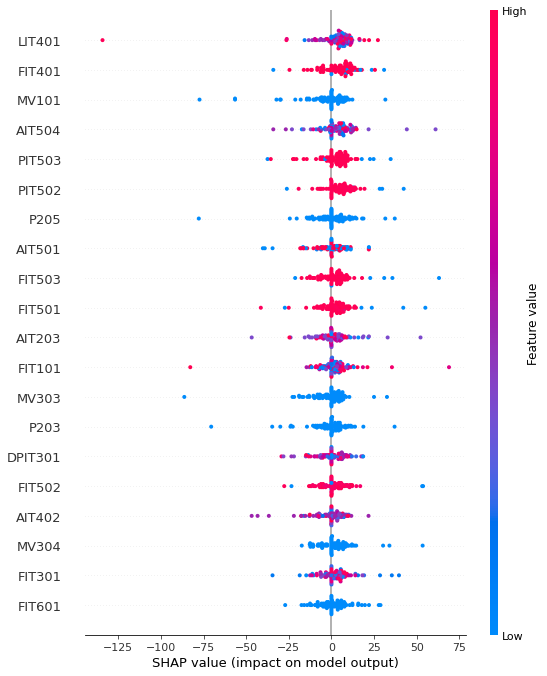

In [226]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

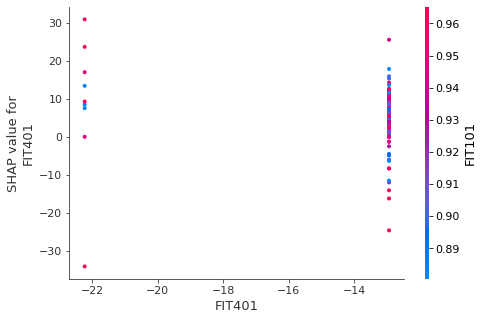

In [227]:
shap.dependence_plot("FIT401", shap_values_1, sample)

In [245]:
shap_result = pd.DataFrame(np.mean(shap_values_1,axis=0), index = train_scale.columns, columns = ['result'])

In [246]:
shap_result.sort_values(by=['result'], ascending=False)

,result
PIT502,5.295072
FIT401,4.872168
AIT504,3.439959
PIT503,2.825302
FIT503,2.797557
LIT401,2.747829
FIT501,2.492606
MV304,2.481920
PIT501,2.439003
FIT301,2.292541


### LIME

In [228]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 5.5 MB/s 


In [229]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [230]:
lime = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [231]:
def lime_explainer(sample):
  score = []
  n_sample = len(sample)
  for i in (range(n_sample)):
    score.append(lime_explainer.explain_instance(sample.iloc[i], model.decision_function, num_features=51))
  return score

In [ ]:
# exp = lime_explainer(sample)

In [232]:
start = timeit.default_timer()
a = lime.explain_instance(sample.iloc[10], model.decision_function, num_features=20)
end = timeit.default_timer()

Intercept 74.21211844014137
Prediction_local [60.46734335]
Right: 75.10447531972649


In [233]:
print(end-start)

42.48940752999988


In [234]:
a.show_in_notebook(show_table=False)

In [235]:
start = timeit.default_timer()
sp_obj = submodular_pick.SubmodularPick(lime, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()

Requested sample size larger than
                              size of input data. Using all data


Intercept 74.60390542994094
Prediction_local [61.5642252]
Right: 73.87049897098218
Intercept 74.73295004385169
Prediction_local [61.38554364]
Right: 80.24799439019783
Intercept 75.33533896235306
Prediction_local [60.68495517]
Right: 75.54861386866116
Intercept 73.16933420551509
Prediction_local [63.3418585]
Right: 79.96459450026283
Intercept 74.6738447768388
Prediction_local [61.61083504]
Right: 74.8609951960779
Intercept 74.15158029626673
Prediction_local [63.59021224]
Right: 78.22467865702501
Intercept 74.07928106588008
Prediction_local [64.15078421]
Right: 170.0290216465911
Intercept 75.37057008130077
Prediction_local [61.02109456]
Right: 75.924389866755
Intercept 73.95961092107217
Prediction_local [62.09294263]
Right: 75.10335048900237
Intercept 74.63192767899316
Prediction_local [62.61097988]
Right: 81.80143328854898
Intercept 74.14196998118628
Prediction_local [61.53817408]
Right: 75.78438376112192
Intercept 73.25431331780867
Prediction_local [63.21402037]
Right: 171.609011346974

In [236]:
print(end-start)

2943.254785631998


[<Figure size 432x288 with 1 Axes>]

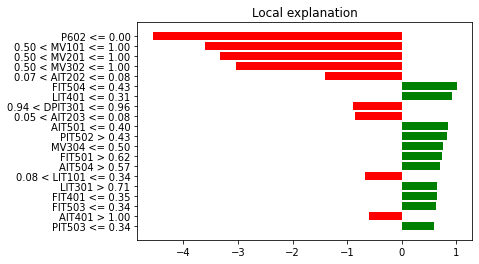

In [237]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

In [244]:
sp_obj.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.5633018598265505),
 ('0.50 < MV101 <= 1.00', -3.5966898106518204),
 ('0.50 < MV201 <= 1.00', -3.3379604070346245),
 ('0.50 < MV302 <= 1.00', -3.037798804169436),
 ('0.07 < AIT202 <= 0.08', -1.4113752823124912),
 ('FIT504 <= 0.43', 1.013354594501889),
 ('LIT401 <= 0.31', 0.9270328121217773),
 ('0.94 < DPIT301 <= 0.96', -0.8905035228167837),
 ('0.05 < AIT203 <= 0.08', -0.8647411879362771),
 ('AIT501 <= 0.40', 0.8473926625148652),
 ('PIT502 > 0.43', 0.8382403956664073),
 ('MV304 <= 0.50', 0.7651950031734976),
 ('FIT501 > 0.62', 0.7394158502555074),
 ('AIT504 > 0.57', 0.7037743415829109),
 ('0.08 < LIT101 <= 0.34', -0.6796346715552359),
 ('LIT301 > 0.71', 0.6526278102414579),
 ('FIT401 <= 0.35', 0.6508935037435755),
 ('FIT503 <= 0.34', 0.6193318921413671),
 ('AIT401 > 1.00', -0.5965323214146349),
 ('PIT503 <= 0.34', 0.5858698688992994)]

###ALE

In [115]:
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 445 kB 5.3 MB/s 
     |████████████████████████████████| 60 kB 8.3 MB/s 
     |████████████████████████████████| 4.7 MB 70.0 MB/s 
     |████████████████████████████████| 98.5 MB 108 kB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.1 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 


In [238]:
from alibi.explainers import ALE

In [239]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)

In [ ]:
start = timeit.default_timer()
exp_ale = ale.explain(sample.to_numpy())
end = timeit.default_timer()

In [ ]:
exp_ale.feature_names

##CASE STUDY attack no.
model can detect the anomaly point